In [2]:
import torch
import requests
import numpy as np
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import importlib
import sys
import cv2
sys.path.append('./matteformer')
import segmentation_refinement as refine
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
from matteformer.inference import build_model,matting
matteformer=build_model()
refiner=refine.Refiner(device='cuda:0')
def det(img,prompt):
    img_input = transform(img).unsqueeze(0)
    H,W=img_input.shape[2:]
    with torch.no_grad():
        preds = model(transforms.Resize((352, 352))(img_input), prompt)[0]
        preds=torch.nn.functional.interpolate(torch.sigmoid(preds),(H,W),mode='bilinear')
    trimap=preds.squeeze().cpu().numpy()
    trimap=cv2.GaussianBlur(trimap,(5,5),0)
    trimap=(trimap-np.min(trimap))/(np.max(trimap)-np.min(trimap))
    image=img_input.numpy()[0].transpose((1,2,0))
    alpha1=matting(matteformer,image,trimap)
    trimap=(trimap*255).astype('uint8')
    alpha=refiner.refine(image, trimap, fast=False, L=512) 
    return alpha1,alpha,trimap


    




/home/yoctta/anaconda3/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Load and normalize `example_image.jpg`. You can also load through an URL.

/home/yoctta/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:4058: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


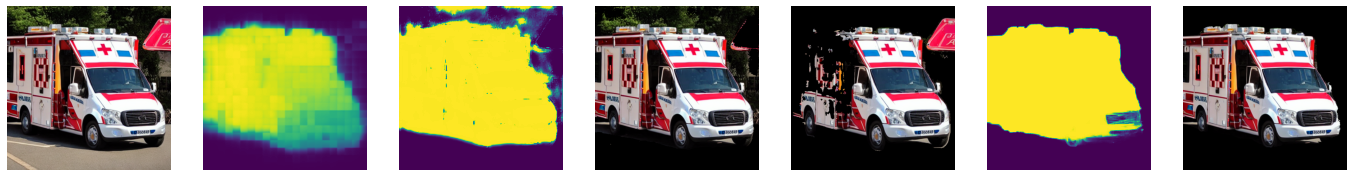

In [15]:
# load and normalize image



name='ambulance'
prompt=('an' if name[0] in 'aeiou' else 'a') + ' '+ name 
img_path='/mnt/home/syn4det/LVIS_gen_FG_3/%s_28.png'%name
input_image = Image.open(img_path).convert('RGB')

alpha1,alpha,trimap=det(input_image,prompt)
_, ax = plt.subplots(1, 7, figsize=(24, 6))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
ax[1].imshow(trimap)
ax[2].imshow(alpha)
RGBA=cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
cv_img=cv2.cvtColor(RGBA[:,:,:3],cv2.COLOR_BGR2RGB)
ax[3].imshow((alpha[...,None]>0)*cv_img)
ax[4].imshow(cv_img*(RGBA[:,:,3:]>0))
ax[5].imshow(alpha1)
ax[6].imshow((alpha1[...,None]>0)*cv_img)
plt.savefig("output.png")

/mnt/data/LVIS_retrieval/masks/selfreformer/ambulance/052cc20a215c7fdde5595d760b4ec180.jpg.png


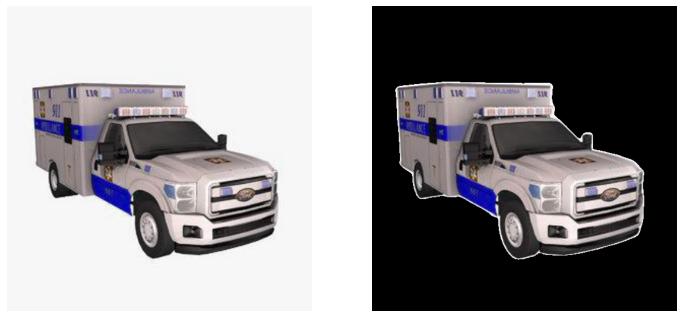

In [14]:
import os
name='ambulance'
id=10
files=os.listdir('/mnt/data/LVIS_retrieval/masks/selfreformer/{}'.format(name))
img_path=os.path.join('/mnt/data/LVIS_retrieval/masks/selfreformer/',name,files[id])
print(img_path)
RGBA=cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
RGBA=cv2.resize(RGBA,(512,512))
cv_img=cv2.cvtColor(RGBA[:,:,:3],cv2.COLOR_BGR2RGB)
_, ax = plt.subplots(1, 2, figsize=(12, 6))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(cv_img)
ax[1].imshow(cv_img*(RGBA[:,:,3:]>0))
plt.savefig("output.png")

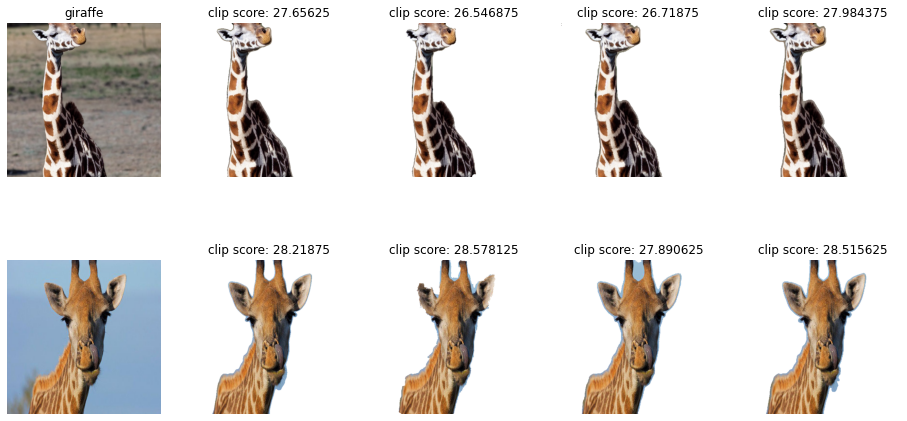

In [28]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np 
sub_dir='LVIS_gen_FG_3'
name='giraffe'
id=53
seg_methods=['selfreformer','clipseg','UFO','U2Net']
img_path=f'/mnt/home/syn4det/{sub_dir}/{name}_{id}.png'
masks=[cv2.imread(f'/mnt/home/syn4det/reseg/{seg_method}/{sub_dir}/{name}_{id}.png') for seg_method in seg_methods]
RGBA=cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
cv_img=cv2.cvtColor(RGBA[:,:,:3],cv2.COLOR_BGR2RGB)
mask_imgs=[(cv_img*(mask>0).astype('uint8')+255*(mask<=0).astype('uint8')) for mask in masks]
_, ax = plt.subplots(2, 5, figsize=(16, 8))
[a.axis('off') for a in ax.flatten()]
ax[0][0].imshow(cv_img)
ax[0][0].set_title(name)
clip_scores=[results[-1][seg_method][class_map[name]]['clip_scores'][id] for seg_method in range(4)]
for i in range(len(mask_imgs)):
    ax[0][i+1].imshow(mask_imgs[i])
    ax[0][i+1].set_title('clip score: {}'.format(clip_scores[i]))
retr_path=list(retr[0][name].keys())[id]
retr_clip_scores=[retr[i][name][retr_path] for i in range(4)]
retr_imgs=[cv2.imread(os.path.join('/mnt/data/LVIS_retrieval/masks/',seg_methods[i],name,retr_path)+'.png',cv2.IMREAD_UNCHANGED) for i in range(4)]
retr_mask_imgs=[(img[:,:,:3]*(img[:,:,3:]>0).astype('uint8')+255*(img[:,:,3:]<=0)*np.ones_like(img[:,:,:3])) for img in retr_imgs]
ax[1][0].imshow(retr_imgs[0][:,:,:3])
for i in range(len(retr_mask_imgs)):
    ax[1][i+1].imshow(retr_mask_imgs[i])
    ax[1][i+1].set_title('clip score: {}'.format(retr_clip_scores[i]))
plt.savefig("output.pdf")

In [18]:
[i for i in enumerate(results[-1][0][class_map['birdhouse']]['clip_scores']) if 27.66<i[1]<27.68]

[(41, 27.671875), (46, 27.671875)]

In [3]:
import json 
import numpy as np
seg_methods=['selfreformer','clipseg','UFO','U2Net']
sub_dirs=['LVIS_gen_FG_3','LVIS_gen_FG_4','LVIS_gen_FG_5']
results=[[json.load(open(f'/mnt/home/syn4det/reseg/{seg_method}/{sub_dir}/results.json')) for seg_method in seg_methods] for sub_dir in sub_dirs]
d=[]
retr=[json.load(open('/mnt/data/LVIS_retrieval/results_{}.json'.format(i))) for i in seg_methods]
for i in results:
    d.append([])
    for t in i:
        for j in t:
            j['clip_score_mean']=np.mean(j['clip_scores'])
        d[-1].append(np.mean([j['clip_score_mean'] for j in t]))



dog 41


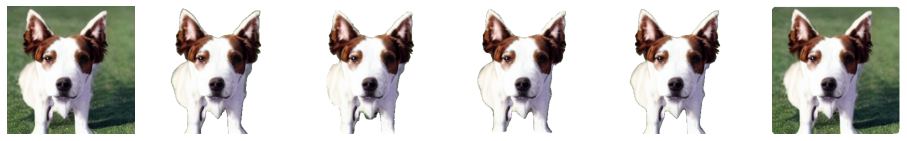

In [109]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np 
import random
sub_dir='LVIS_gen_FG'
name=random.choice(list(class_map.keys()))
name='dog'
id=np.random.randint(1,99)
print(name,id)
seg_methods=['selfreformer','clipseg','UFO','U2Net','detectron']
img_path=f'/mnt/home/syn4det/{sub_dir}/{name}_{id}.png'
masks=[cv2.imread(f'/mnt/home/syn4det/reseg/{seg_method}/{sub_dir}/{name}_{id}.png') for seg_method in seg_methods]
RGBA=cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
cv_img=cv2.cvtColor(RGBA[:,:,:3],cv2.COLOR_BGR2RGB)
mask_imgs=[(cv_img*(mask>128).astype('uint8')+255*(mask<=128).astype('uint8')) for mask in masks]
_, ax = plt.subplots(1, 6, figsize=(16, 8))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(cv_img)
#ax[0].set_title(name)
for i in range(len(mask_imgs)):
    ax[i+1].imshow(mask_imgs[i])

In [108]:
id=2
cv2.imwrite(f'Segs/{id}_in.png',cv2.cvtColor(cv_img,cv2.COLOR_BGR2RGB))
cv2.imwrite(f'Segs/{id}_selfreformer.png',cv2.cvtColor(mask_imgs[0],cv2.COLOR_BGR2RGB))
cv2.imwrite(f'Segs/{id}_CLIPseg.png',cv2.cvtColor(mask_imgs[1],cv2.COLOR_BGR2RGB))
cv2.imwrite(f'Segs/{id}_UFO.png',cv2.cvtColor(mask_imgs[2],cv2.COLOR_BGR2RGB))
cv2.imwrite(f'Segs/{id}_U2Net.png',cv2.cvtColor(mask_imgs[3],cv2.COLOR_BGR2RGB))

True

In [4]:
bar=26
d2=[]
for i in results:
    d2.append([])
    for t in i:
        for j in t:
            j['valid_count_%s'%bar]=np.sum(np.array(j['clip_scores'])>=bar)
        d2[-1].append(np.sum([j['valid_count_%s'%bar] for j in t]))
for i in d2:
    print(i)

[36770, 28186, 33428, 37361]
[45097, 33731, 42276, 45826]
[45239, 34006, 42465, 45980]
[45128, 34124, 42459, 45818]
[45170, 33967, 42459, 45898]


In [5]:
s=results[-1][0]
s=[dict(name=i['name'],id=i['id'],image_count=i['image_count'],clip_score_mean=i['clip_score_mean'],valid_count_26=i['valid_count_26']) for i in s]
s=sorted(s,key=lambda x:x['clip_score_mean'])

In [6]:
for i in s[:20]:
    print(i)

{'name': 'jam', 'id': 590, 'image_count': 16, 'clip_score_mean': 13.795703125, 'valid_count_26': 0}
{'name': 'gag', 'id': 481, 'image_count': 4, 'clip_score_mean': 15.645, 'valid_count_26': 0}
{'name': 'milestone', 'id': 688, 'image_count': 4, 'clip_score_mean': 16.56, 'valid_count_26': 0}
{'name': 'cover', 'id': 1105, 'image_count': 136, 'clip_score_mean': 16.849296875, 'valid_count_26': 0}
{'name': 'receipt', 'id': 877, 'image_count': 61, 'clip_score_mean': 17.348359375, 'valid_count_26': 0}
{'name': 'jean', 'id': 592, 'image_count': 1927, 'clip_score_mean': 17.92046875, 'valid_count_26': 0}
{'name': 'vent', 'id': 1141, 'image_count': 1468, 'clip_score_mean': 18.311171875, 'valid_count_26': 0}
{'name': 'tinsel', 'id': 1092, 'image_count': 12, 'clip_score_mean': 18.36390625, 'valid_count_26': 6}
{'name': 'medicine', 'id': 683, 'image_count': 34, 'clip_score_mean': 18.370546875, 'valid_count_26': 0}
{'name': 'beeper', 'id': 82, 'image_count': 4, 'clip_score_mean': 18.5103125, 'valid_co

In [7]:
class_map={results[-1][0][i]['name']:i for i in range(len(results[-1][0]))}

In [50]:
results[-1][0][class_map['gag']]

{'name': 'gag',
 'instance_count': 4,
 'def': "restraint put into a person's mouth to prevent speaking or shouting",
 'synonyms': ['gag', 'muzzle'],
 'image_count': 4,
 'id': 481,
 'frequency': 'r',
 'synset': 'gag.n.02',
 'clip_scores': [14.8671875,
  15.546875,
  16.6875,
  17.46875,
  17.203125,
  13.84375,
  15.6484375,
  15.8828125,
  15.2109375,
  16.3125,
  16.875,
  15.5,
  16.03125,
  15.9609375,
  15.953125,
  15.8203125,
  14.65625,
  15.109375,
  18.59375,
  15.7109375,
  15.0546875,
  14.7734375,
  17.75,
  17.65625,
  13.5546875,
  16.0625,
  16.4375,
  20.1875,
  14.7890625,
  19.53125,
  15.0078125,
  14.140625,
  16.3125,
  12.3828125,
  16.15625,
  14.171875,
  14.921875,
  16.390625,
  17.03125,
  15.875,
  15.8671875,
  17.109375,
  14.2578125,
  15.9765625,
  16.125,
  15.859375,
  16.640625,
  13.203125,
  14.3359375,
  14.625,
  18.015625,
  15.3125,
  15.53125,
  16.78125,
  16.78125,
  16.5,
  12.9609375,
  14.1484375,
  15.625,
  13.8515625,
  17.671875,
  16.

In [55]:
from collections import defaultdict
datadict=defaultdict(list)
bar=25
belief=1
for i in range(len(results)):
    sub_dir=sub_dirs[i]
    ct=results[i]
    for c in zip(*ct):
        npc=np.stack([np.array(j['clip_scores']) for j in c],0)
        name=c[0]['name']
        cid=c[0]['id']-1
        npx=np.argmax(npc,0)
        this_bar=min(bar,np.max(npc)-belief)
        for k in range(len(npx)):
            if npc[npx[k],k]<this_bar:
                continue
            seg_method=seg_methods[npx[k]]
            datadict[cid].append('|'.join([f'/mnt/home/syn4det/{sub_dir}/{name}_{k}.png',f'/mnt/home/syn4det/reseg/{seg_method}/{sub_dir}/{name}_{k}.png']))

In [56]:
print(len(datadict))
print(np.sum([len(datadict[i]) for i in datadict]))
class_name_map={results[-1][0][i]['id']-1:results[-1][0][i]['name'] for i in range(len(results[-1][0]))}
[class_name_map[i] for i in set(range(1203))-set(datadict)]

1203
376048


[]

In [57]:
with open('/mnt/home/syn4det/InstPool4.json','w') as f:
    json.dump(datadict,f)


In [7]:
import json 
import numpy as np
sub_dirs=['LVIS_gen_FG_5','LVIS_gen_FG_6','LVIS_gen_FG_7','LVIS_gen_FG_8','LVIS_gen_FG_9']
results=[json.load(open(f'/mnt/home/syn4det/{sub_dir}/results.json'))for sub_dir in sub_dirs]
from collections import defaultdict
datadict=defaultdict(list)
bar=25
belief=1
umap={i['id']-1:i['name'] for i in results[0]}
for i in results:
    for j in i:
        datadict[j['id']-1]+=j['clip_scores']
clip_score_mean={i:np.mean(datadict[i]) for i in datadict}
res=defaultdict(list)
print(np.mean(list(clip_score_mean.values())))
for i in datadict:
    this_bar=min(bar,np.max(datadict[i])-belief)
    for k in range(len(datadict[i])):
        if datadict[i][k]<this_bar:
            continue
        this_dir=sub_dirs[k//100]
        ind=k%100
        res[i].append(f'/mnt/home/syn4det/{this_dir}/{umap[i]}_{ind}.png')
print(np.sum([len(i) for i in res.values()]))
with open('/mnt/home/syn4det/InstPool4.json') as f:
    old=json.load(f)

for i in old:
    old[i]+=res[i]

with open('/mnt/home/syn4det/InstPool5.json','w') as f:
    json.dump(old,f)

25.402292484933497
355868
['/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_0.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_1.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_2.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_3.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_4.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_5.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_7.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_8.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_9.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_10.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_11.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_12.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_13.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_14.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_15.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_16.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_21.png', '/mnt/home/syn4det/LVIS_gen_FG_5/aerosol_can_22.png', '/mnt/home

In [63]:
for i in datadict[0]:
    m1=i.split('|')[1]
    if cv2.imread(m1,0) is None:
        print(m1)

libpng error: IDAT: CRC error


/mnt/home/syn4det/reseg/selfreformer/LVIS_gen_FG/aerosol_can_11.png


libpng error: IDAT: incorrect data check


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_18.png


libpng error: IDAT: incorrect data check


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_19.png


libpng error: IDAT: CRC error


/mnt/home/syn4det/reseg/selfreformer/LVIS_gen_FG/aerosol_can_27.png


libpng error: IDAT: incorrect data check


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_33.png


libpng error: IDAT: CRC error


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_34.png


libpng error: IDAT: CRC error


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_44.png


libpng error: bad adaptive filter value


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_47.png


libpng error: IDAT: CRC error


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_55.png


libpng error: IDAT: incorrect data check


/mnt/home/syn4det/reseg/selfreformer/LVIS_gen_FG/aerosol_can_60.png
/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_80.png


libpng error: IDAT: CRC error
libpng error: IDAT: incorrect data check


/mnt/home/syn4det/reseg/UFO/LVIS_gen_FG/aerosol_can_94.png


In [75]:
from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
a=Image.open('/mnt/home/syn4det/reseg/selfreformer/LVIS_gen_FG/aerosol_can_11.png')
d=np.array(a)
d

array([[ 16,  18,  22, ...,   3,   2,   2],
       [ 13,  14,  15, ...,   2,   2,   1],
       [ 10,  10,  12, ...,   1,   1,   1],
       ...,
       [190, 198, 219, ...,   0,   0,   0],
       [182, 201, 219, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)